# Topic 19 Part 2: Feature Selection & Model Validation


- onl01-dtsc-ft-022221
- 04/09/21

## LEARNING OBJECTIVES

#### Part 1 (04/08/21)
- Learn how to expand our last lesson to include multiple independent variables.
- Learn ways to deal with categorical variables.
- Learn about multicollinearity of features
- Learn about how to improve a baseline model based on results
- Learn how to run a multiple regression using statsmodels

#### Part 2 (Today)
- Feature Scaling & Normalization
- Feature Engineering/Selection
- Model Validation/Cross Validation

## Announcements/Reminders

- Today's Study Group will be ~60 min
- We will Kick Off Phase 2 Project at 4 pm EST today, instead of Feelings Fridays.

## Resources:

### Watch These Central Lecturer Recordings!
- [ ] 📺[Canvas: Topic 20+: Extensions to Linear Models + Feature Engineering/Selection CL Recordings](https://learning.flatironschool.com/courses/2681/pages/topic-20+-extensions-to-linear-models-+-feature-engineering-slash-selection-cl-recordings?module_item_id=188118)


####  OSEMN Workflow Project Repo ( will show off more fully at 4 pm)
- ⭐️ **[Starter OSEMN Data Science Workflow Template Repo](https://drive.google.com/file/d/1Hfenab4oTNuHJak4hH2l9VeMh5M6KkhS/view?usp=sharing)**
    - `index_OSEMN.ipynb`: also included in notes repo

## Questions?



- 

# [New] Feature Engineering/Selection & Model Validation


> Walk through the essential parts of the following notebooks (headers start with  `[022221FT]` )
- [ ] `feature_selection_and_feature_engineering.ipynb`
    
    
- [ ] `model_validation-022221FT.ipynb`

# Activity: Multiple Linear Regression with Movies

## OBTAIN


### Imports And Functions

In [49]:
# ## Importing our study group functions
# %load_ext autoreload
# %autoreload 2
# import sys
    
# py_folder = "../../py_files/" # CHANGE TO REFECT YOUR NOTEBOOKS LOCATION COMPARED TO THE PY_FILES FOLDER
# sys.path.append(py_folder)
# import functions_SG as sg

In [50]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf

from scipy import stats

In [51]:
plt.style.use('seaborn-notebook')
# plt.rcParams['figure.figsize'] = [10,6]
pd.set_option('display.float_format', lambda x: f"{x:,}")
pd.set_option('display.max_columns',0)

In [52]:
### NEW MOVIE DATASET

def load_movie_data(verbose=True,include_genre=False):
    ## Thanks to Johnny Dryma for letting us use his data
    movie_data_url = "https://raw.githubusercontent.com/Drymander/dsc-phase-1-project/master/data/2012-2019%20FULL.csv"
    dfm = pd.read_csv(movie_data_url,index_col=0,parse_dates=['release_date'])

    ## List of cols that need processsing before use
    # cols_need_processing=['genres','production_companies',
    #                       'belongs_to_collection']

    ## Save only the columns of interest
    df = dfm[['id','imdb_id','original_title','title','genres','mpaa_rating',
         'release_date','runtime','budget','revenue',
         'vote_count','vote_average','popularity','adult','original_language']].copy()

    ## Keep only movies with financial data
    df=df[(df['budget']>0) & (df['revenue']>0)]

    if include_genre==True:
        df['genre_list'] = df['genres'].map(lambda x: eval(x))
        df['genre_list'] = df['genre_list'].map(lambda x: [g['name'] for g in x])
    else:
        ## Dropping genres isntead
        df.drop(columns=['genres'],inplace=True)
        
    ## Feature Engineering
    # df['profit'] = df['revenue'] - df['budget']
    # df['ROI'] = df['profit']/df['budget']

    ## Removing Extreme values for class purposes
    # df=df[df['ROI']<1000]

    ## Drop nulls & reset index
    df.dropna(inplace=True)
    df.set_index('id',inplace=True)

    if verbose:
        display(df.head(),df.info())
    return df

def plot_data(data,X='budget',y='revenue',fit_reg=False):
    priceFmt = mpl.ticker.StrMethodFormatter("${x:,.0f}")
    ax = sns.regplot(x=X,y=y,data=data,fit_reg=fit_reg)
    ax.yaxis.set_major_formatter(priceFmt)
    fig=ax.get_figure()
    return fig,ax

### Load Data

In [53]:
df = load_movie_data(verbose=False)
df.head()

,imdb_id,original_title,title,mpaa_rating,release_date,runtime,budget,revenue,vote_count,vote_average,popularity,adult,original_language
id,,,,,,,,,,,,,
24428,tt0848228,The Avengers,The Avengers,PG-13,2012-04-25,143.0,220000000,1518815515,24252,7.7,151.095,False,en
50620,tt1673434,The Twilight Saga: Breaking Dawn - Part 2,The Twilight Saga: Breaking Dawn - Part 2,PG-13,2012-11-13,115.0,120000000,829000000,6978,6.5,73.226,False,en
82690,tt1772341,Wreck-It Ralph,Wreck-It Ralph,PG,2012-11-01,101.0,165000000,471222889,9690,7.3,70.213,False,en
57214,tt1636826,Project X,Project X,R,2012-03-01,88.0,12000000,100000000,4399,6.7,67.687,False,en
49051,tt0903624,The Hobbit: An Unexpected Journey,The Hobbit: An Unexpected Journey,PG-13,2012-11-26,169.0,250000000,1021103568,14539,7.3,61.052,False,en


In [54]:
## Check dtypes,etc
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 24428 to 630331
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   imdb_id            1300 non-null   object        
 1   original_title     1300 non-null   object        
 2   title              1300 non-null   object        
 3   mpaa_rating        1300 non-null   object        
 4   release_date       1300 non-null   datetime64[ns]
 5   runtime            1300 non-null   float64       
 6   budget             1300 non-null   int64         
 7   revenue            1300 non-null   int64         
 8   vote_count         1300 non-null   int64         
 9   vote_average       1300 non-null   float64       
 10  popularity         1300 non-null   float64       
 11  adult              1300 non-null   bool          
 12  original_language  1300 non-null   object        
dtypes: bool(1), datetime64[ns](1), float64(3), int64(3), obje

In [55]:
# plot_data(X='budget',y='revenue',data=df,fit_reg=True);

## SCRUB

In [56]:
## Check nulls
df.isnull().sum()

imdb_id              0
original_title       0
title                0
mpaa_rating          0
release_date         0
runtime              0
budget               0
revenue              0
vote_count           0
vote_average         0
popularity           0
adult                0
original_language    0
dtype: int64

In [57]:
## Inspect the numeric columns
df.describe()

,runtime,budget,revenue,vote_count,vote_average,popularity
count,"1,300.0","1,300.0","1,300.0","1,300.0","1,300.0","1,300.0"
mean,109.34153846153846,"45,900,017.192307696","155,390,520.90076923","3,048.479230769231",6.407538461538461,34.06769615384615
std,16.982950217591988,"55,641,755.675761335","267,617,277.28683838","3,757.7980193390854",0.940552522610109,37.70137389978608
min,78.0,10.0,1.0,0.0,0.0,0.6
25%,96.0,"10,000,000.0","10,276,110.0",602.0,5.9,14.20425
50%,107.0,"25,000,000.0","52,410,264.5","1,638.5",6.4,22.548499999999997
75%,119.0,"58,850,000.0","170,262,729.25","4,059.5",7.0,38.3885
max,188.0,"356,000,000.0","2,797,800,564.0","25,296.0",9.0,397.257


In [58]:
df.nunique()

imdb_id              1300
original_title       1300
title                1300
mpaa_rating             6
release_date          928
runtime                89
budget                232
revenue              1297
vote_count           1154
vote_average           50
popularity           1283
adult                   1
original_language       1
dtype: int64

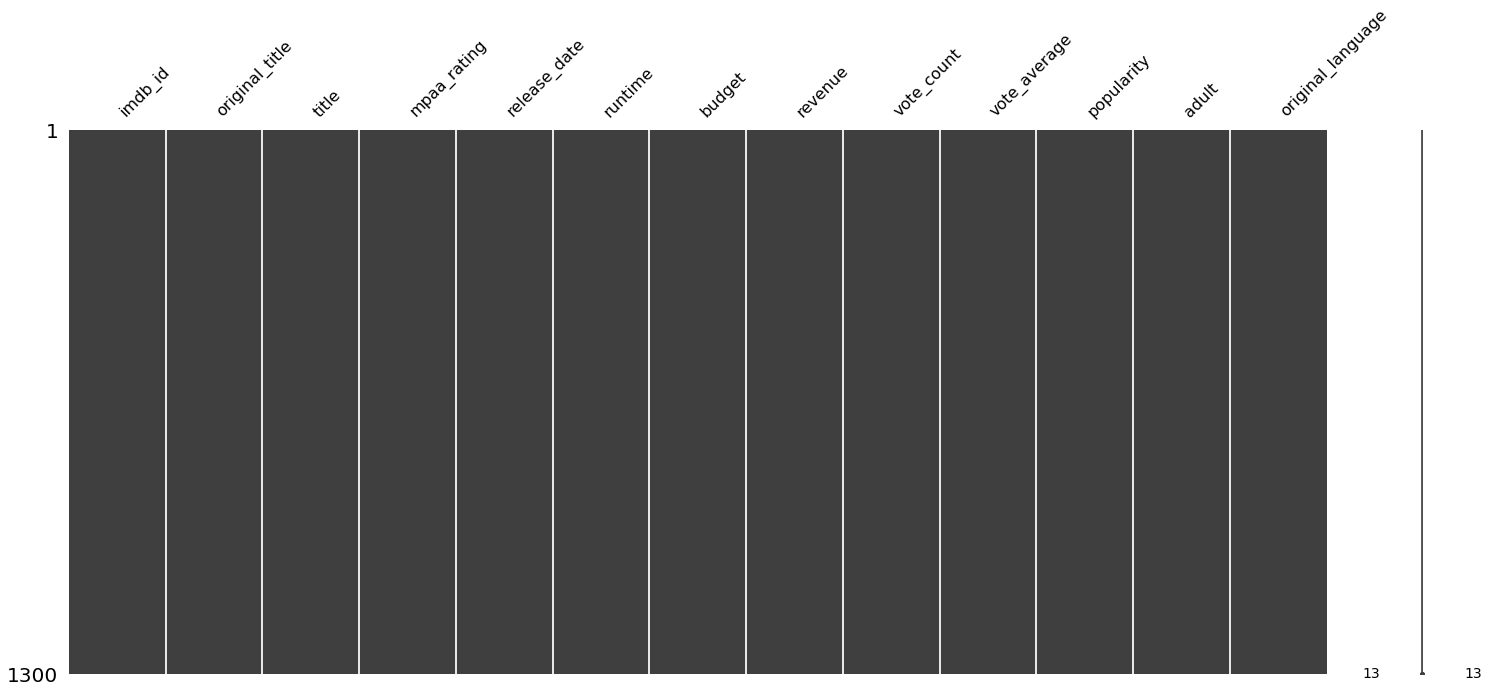

In [59]:
import missingno
missingno.matrix(df)

## Explore

> We kind of skipped over this phase completely yesterday

In [60]:
def plot_column_vs_target():
    pass

## Feature Engineering

### Encode Categorical Data

In [61]:
## Remake final cat cols
cat_cols = ['mpaa_rating']

In [62]:
## Create encoded vars
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first')
encoder

OneHotEncoder(drop='first', sparse=False)

In [63]:
## make encoded vars_df
data_ohe = encoder.fit_transform(df[cat_cols])
df_ohe = pd.DataFrame(data_ohe,columns=encoder.get_feature_names(cat_cols),
                     index=df.index)
df_ohe

/Users/codingdojo/opt/anaconda3/envs/dojo-env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,mpaa_rating_NC-17,mpaa_rating_NR,mpaa_rating_PG,mpaa_rating_PG-13,mpaa_rating_R
id,,,,,
24428,0.0,0.0,0.0,1.0,0.0
50620,0.0,0.0,0.0,1.0,0.0
82690,0.0,0.0,1.0,0.0,0.0
57214,0.0,0.0,0.0,0.0,1.0
49051,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...
403300,0.0,0.0,0.0,1.0,0.0
520900,0.0,0.0,1.0,0.0,0.0
616584,0.0,0.0,0.0,0.0,1.0


In [64]:
## Create df model from original df and df_ohe
df_model = pd.concat([df.drop('mpaa_rating',axis=1),df_ohe],axis=1)
df_model

,imdb_id,original_title,title,release_date,runtime,budget,revenue,vote_count,vote_average,popularity,adult,original_language,mpaa_rating_NC-17,mpaa_rating_NR,mpaa_rating_PG,mpaa_rating_PG-13,mpaa_rating_R
id,,,,,,,,,,,,,,,,,
24428,tt0848228,The Avengers,The Avengers,2012-04-25,143.0,220000000,1518815515,24252,7.7,151.095,False,en,0.0,0.0,0.0,1.0,0.0
50620,tt1673434,The Twilight Saga: Breaking Dawn - Part 2,The Twilight Saga: Breaking Dawn - Part 2,2012-11-13,115.0,120000000,829000000,6978,6.5,73.226,False,en,0.0,0.0,0.0,1.0,0.0
82690,tt1772341,Wreck-It Ralph,Wreck-It Ralph,2012-11-01,101.0,165000000,471222889,9690,7.3,70.213,False,en,0.0,0.0,1.0,0.0,0.0
57214,tt1636826,Project X,Project X,2012-03-01,88.0,12000000,100000000,4399,6.7,67.687,False,en,0.0,0.0,0.0,0.0,1.0
49051,tt0903624,The Hobbit: An Unexpected Journey,The Hobbit: An Unexpected Journey,2012-11-26,169.0,250000000,1021103568,14539,7.3,61.052,False,en,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403300,tt5827916,A Hidden Life,A Hidden Life,2019-12-11,174.0,9000000,4612788,370,7.2,15.434,False,en,0.0,0.0,0.0,1.0,0.0
520900,tt6439020,The Personal History of David Copperfield,The Personal History of David Copperfield,2019-11-07,119.0,15600000,11620337,211,6.7,15.076,False,en,0.0,0.0,1.0,0.0,0.0
616584,tt10521814,K-12,K-12,2019-09-05,92.0,50000,359377,171,7.6,14.822,False,en,0.0,0.0,0.0,0.0,1.0


In [65]:
## Drop columns we don't want to use in the model
drop_cols = ['title','imdb_id','original_title','release_date','adult',
             'original_language']
df_model.drop(columns=drop_cols,inplace=True)
df_model

,runtime,budget,revenue,vote_count,vote_average,popularity,mpaa_rating_NC-17,mpaa_rating_NR,mpaa_rating_PG,mpaa_rating_PG-13,mpaa_rating_R
id,,,,,,,,,,,
24428,143.0,220000000,1518815515,24252,7.7,151.095,0.0,0.0,0.0,1.0,0.0
50620,115.0,120000000,829000000,6978,6.5,73.226,0.0,0.0,0.0,1.0,0.0
82690,101.0,165000000,471222889,9690,7.3,70.213,0.0,0.0,1.0,0.0,0.0
57214,88.0,12000000,100000000,4399,6.7,67.687,0.0,0.0,0.0,0.0,1.0
49051,169.0,250000000,1021103568,14539,7.3,61.052,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
403300,174.0,9000000,4612788,370,7.2,15.434,0.0,0.0,0.0,1.0,0.0
520900,119.0,15600000,11620337,211,6.7,15.076,0.0,0.0,1.0,0.0,0.0
616584,92.0,50000,359377,171,7.6,14.822,0.0,0.0,0.0,0.0,1.0


In [66]:
df_model.describe()

,runtime,budget,revenue,vote_count,vote_average,popularity,mpaa_rating_NC-17,mpaa_rating_NR,mpaa_rating_PG,mpaa_rating_PG-13,mpaa_rating_R
count,"1,300.0","1,300.0","1,300.0","1,300.0","1,300.0","1,300.0","1,300.0","1,300.0","1,300.0","1,300.0","1,300.0"
mean,109.34153846153846,"45,900,017.192307696","155,390,520.90076923","3,048.479230769231",6.407538461538461,34.06769615384615,0.0007692307692307692,0.016923076923076923,0.13307692307692306,0.3830769230769231,0.4592307692307692
std,16.982950217591988,"55,641,755.675761335","267,617,277.28683838","3,757.7980193390854",0.940552522610109,37.70137389978608,0.027735009811261455,0.12903291709239778,0.33978856386766754,0.48632388956748096,0.49852687591716155
min,78.0,10.0,1.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0
25%,96.0,"10,000,000.0","10,276,110.0",602.0,5.9,14.20425,0.0,0.0,0.0,0.0,0.0
50%,107.0,"25,000,000.0","52,410,264.5","1,638.5",6.4,22.548499999999997,0.0,0.0,0.0,0.0,0.0
75%,119.0,"58,850,000.0","170,262,729.25","4,059.5",7.0,38.3885,0.0,0.0,0.0,1.0,1.0
max,188.0,"356,000,000.0","2,797,800,564.0","25,296.0",9.0,397.257,1.0,1.0,1.0,1.0,1.0


## New Assumption: No Multicollinearity

### Multicollinearity
- An additional concern to check for.
- Rule of thumb is if correlation between vars is >0.70 is too high


In [67]:
## Get the correlation matrix for our model_df (without the target)
corr = df_model.drop('revenue',axis=1).corr()
corr.round(2)

,runtime,budget,vote_count,vote_average,popularity,mpaa_rating_NC-17,mpaa_rating_NR,mpaa_rating_PG,mpaa_rating_PG-13,mpaa_rating_R
runtime,1.0,0.41,0.45,0.38,0.28,0.04,-0.08,-0.18,0.17,-0.02
budget,0.41,1.0,0.64,0.19,0.53,-0.02,-0.09,0.18,0.25,-0.36
vote_count,0.45,0.64,1.0,0.43,0.51,-0.01,-0.09,-0.02,0.17,-0.13
vote_average,0.38,0.19,0.43,1.0,0.25,-0.0,-0.12,0.08,0.04,-0.07
popularity,0.28,0.53,0.51,0.25,1.0,-0.02,-0.08,-0.0,0.14,-0.12
mpaa_rating_NC-17,0.04,-0.02,-0.01,-0.0,-0.02,1.0,-0.0,-0.01,-0.02,-0.03
mpaa_rating_NR,-0.08,-0.09,-0.09,-0.12,-0.08,-0.0,1.0,-0.05,-0.1,-0.12
mpaa_rating_PG,-0.18,0.18,-0.02,0.08,-0.0,-0.01,-0.05,1.0,-0.31,-0.36
mpaa_rating_PG-13,0.17,0.25,0.17,0.04,0.14,-0.02,-0.1,-0.31,1.0,-0.73
mpaa_rating_R,-0.02,-0.36,-0.13,-0.07,-0.12,-0.03,-0.12,-0.36,-0.73,1.0


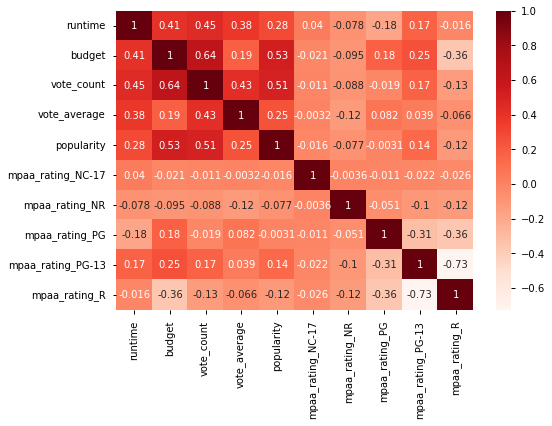

In [68]:
## Plot this as a heatmap
sns.heatmap(corr,annot=True,cmap='Reds')

In [69]:
## Create a mask to make the multiplot easier to look at 
mask = np.zeros_like(corr)
mask

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [70]:
## Fill in the upper right cells with True
mask[np.triu_indices_from(mask)] = True
mask

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

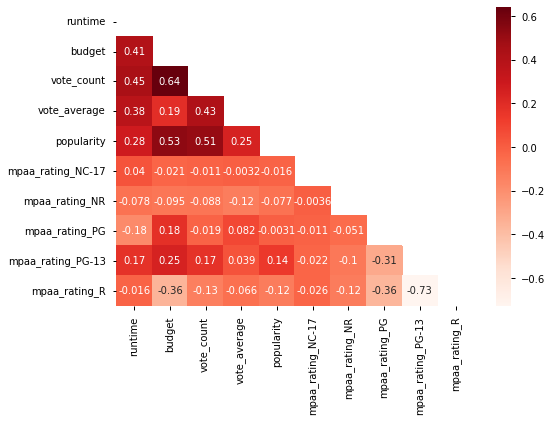

In [71]:
## Plot again, with the mask
sns.heatmap(corr,annot=True,cmap='Reds',mask=mask)

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc58ae0da90>)

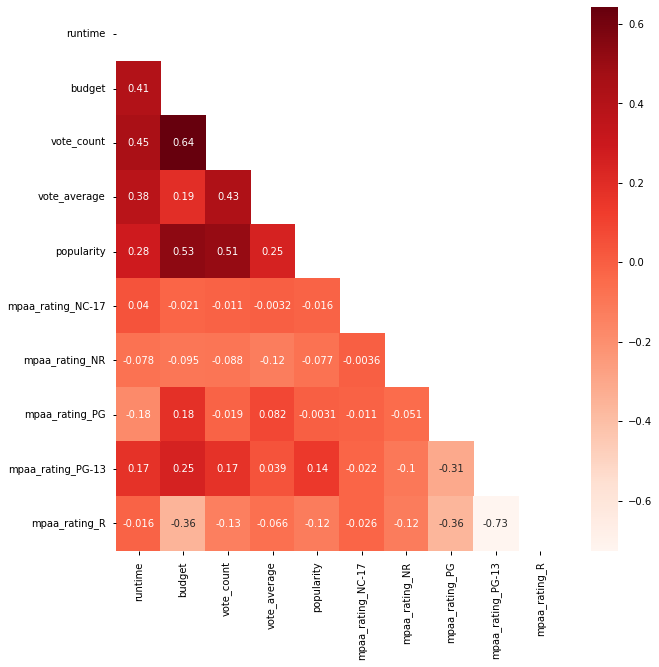

In [72]:
# Functionize

def multiplot(df_model,figsize=(10,10),cmap="Reds"):
    
    corr = df_model.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(corr, annot=True,cmap="Reds",mask=mask)
    return fig, ax


multiplot(df_model.drop('revenue',axis=1))

In [73]:
# multiplot(df_model)

In [74]:
df.corr()['revenue'].round(2)

runtime        0.36
budget         0.79
revenue         1.0
vote_count     0.78
vote_average   0.29
popularity     0.58
adult           NaN
Name: revenue, dtype: float64

In [75]:
# ## Drop any multicollinear features
# # None

# ## Create a string representing the right side of the ~ in our formula
# features = ' + '.join(df_model.drop('revenue',axis=1).columns)

# ## Create the final formula and create the model
# f  = "revenue~"+features

# model = smf.ols(f, df_model).fit()
# model.summary()

> RUH ROH!

### Fixing Statsmodels Formulas

In [76]:
##Fix df column names so there are no spaces
df.columns

Index(['imdb_id', 'original_title', 'title', 'mpaa_rating', 'release_date',
       'runtime', 'budget', 'revenue', 'vote_count', 'vote_average',
       'popularity', 'adult', 'original_language'],
      dtype='object')

In [77]:
## Create a dict with new ratings names from the mpaa_rating col
ratings_list = df['mpaa_rating'].unique()
ratings_list

array(['PG-13', 'PG', 'R', 'NR', 'G', 'NC-17'], dtype=object)

In [78]:
## Replace the original mpaa_rating col
rating_map = {}
for rating in ratings_list:
    rating_map[rating] = rating.replace('-','_')
rating_map

{'PG-13': 'PG_13',
 'PG': 'PG',
 'R': 'R',
 'NR': 'NR',
 'G': 'G',
 'NC-17': 'NC_17'}

In [79]:
df['mpaa_rating'] = df['mpaa_rating'].replace(rating_map)
df['mpaa_rating'].unique()

array(['PG_13', 'PG', 'R', 'NR', 'G', 'NC_17'], dtype=object)

### Prepare df_model again

In [80]:
## Create encoded vars
encoder = OneHotEncoder(sparse=False,drop='first')
ohe_vars = encoder.fit_transform(df[cat_cols])
## make encoded vars a df
df_ohe = pd.DataFrame(ohe_vars,columns=encoder.get_feature_names(cat_cols),
                     index=df.index)
## Create df model from original df and df_ohe
df_model = pd.concat([df.drop(columns=cat_cols),df_ohe],axis=1)

drop_cols = ['title','imdb_id','original_title','release_date','adult',
             'original_language']
df_model.drop(columns=drop_cols,inplace=True)
df_model.head()

/Users/codingdojo/opt/anaconda3/envs/dojo-env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,runtime,budget,revenue,vote_count,vote_average,popularity,mpaa_rating_NC_17,mpaa_rating_NR,mpaa_rating_PG,mpaa_rating_PG_13,mpaa_rating_R
id,,,,,,,,,,,
24428,143.0,220000000,1518815515,24252,7.7,151.095,0.0,0.0,0.0,1.0,0.0
50620,115.0,120000000,829000000,6978,6.5,73.226,0.0,0.0,0.0,1.0,0.0
82690,101.0,165000000,471222889,9690,7.3,70.213,0.0,0.0,1.0,0.0,0.0
57214,88.0,12000000,100000000,4399,6.7,67.687,0.0,0.0,0.0,0.0,1.0
49051,169.0,250000000,1021103568,14539,7.3,61.052,0.0,0.0,0.0,1.0,0.0


(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc58a5a5f10>)

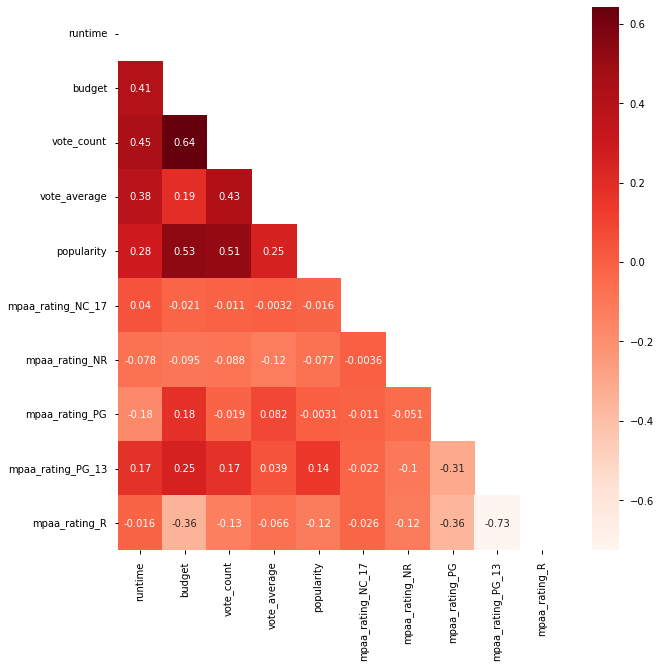

In [81]:
multiplot(df_model.drop('revenue',axis=1))

In [104]:
## Drop any multicollinear features
# None

## Create a string representing the right side of the ~ in our formula
features = ' + '.join(df_model.drop('revenue',axis=1).columns)

## Create the final formula and create the model
f  = "revenue~"+features
f

'revenue~runtime + budget + vote_count + vote_average + popularity + mpaa_rating_NC_17 + mpaa_rating_NR + mpaa_rating_PG + mpaa_rating_PG_13 + mpaa_rating_R'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     425.6
Date:                Thu, 31 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:44:45   Log-Likelihood:                -26122.
No. Observations:                1300   AIC:                         5.227e+04
Df Residuals:                    1289   BIC:                         5.232e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.103e+08   5.38e+07      2.049      0.041    4.68e+06    2.16e+08
runtime           -5.352e+05   2.64e+05     -2.027      0.043   -1.05e+06   -1.71e+04
budget                1.9486      0.103     18.884      0.000       1.746       2.151
vote_count           3.3e+04   1443.482     22.858      0.000    3.02e+04    3.58e+04
vote_average      -4.854e+06   4.58e+06     -1.060      0.290   -1.38e+07    4.13e+06
popularity         1.014e+06   1.18e+05      8.615      0.000    7.83e+05    1.24e+06
mpaa_rating_NC_17 -7.915e+07   1.37e+08     -0.576      0.565   -3.49e+08     1.9e+08
mpaa_rating_NR    -6.745e+07   5.22e+07     -1.291      0.197    -1.7e+08     3.5e+07
mpaa_rating_PG    -2.459e+07   4.44e+07     -0.554      0.580   -1.12e+08    6.25e+07
mpaa_rating_PG_13 -9.351e+07   4.42e+07     -2.116      0.035    -1.8e+08   -6.81e+06
mpaa_rating_R     -1.079e+08   4.45e+07     -2.426      0.015   -1.95e+08   -2.07e+07
==============================================================================
Omnibus:                      849.330   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25908.797
Skew:                           2.547   Prob(JB):                         0.00
Kurtosis:                      24.269   Cond. No.                     2.89e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.89e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

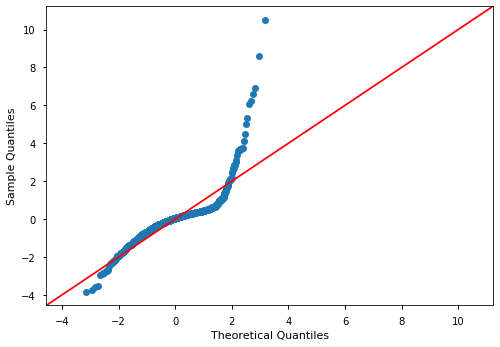

In [82]:
model = smf.ols(f, df_model).fit()
display(model.summary())
sm.graphics.qqplot(model.resid,line='45',fit=True);

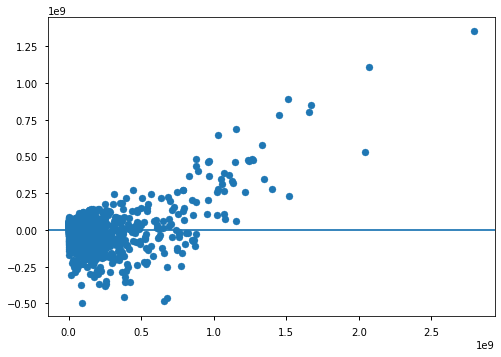

In [83]:
plt.scatter(df_model['revenue'],model.resid)
plt.axhline(0)

In [84]:
model.pvalues[model.pvalues > .05]

vote_average         0.2895249109735031
mpaa_rating_NC_17    0.5648150551069042
mpaa_rating_NR      0.19681669962865406
mpaa_rating_PG       0.5799786181150883
dtype: float64

In [85]:
## Drop any multicollinear features
remove_cols = [col for col in df_model.columns if col.startswith('mpaa')]
remove_cols

['mpaa_rating_NC_17',
 'mpaa_rating_NR',
 'mpaa_rating_PG',
 'mpaa_rating_PG_13',
 'mpaa_rating_R']

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     883.1
Date:                Thu, 31 Mar 2022   Prob (F-statistic):          1.22e-312
Time:                        16:44:46   Log-Likelihood:                -26347.
No. Observations:                1300   AIC:                         5.270e+04
Df Residuals:                    1296   BIC:                         5.272e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -2.462e+08   2.95e+07     -8.332      0.000   -3.04e+08   -1.88e+08
budget           3.1561      0.091     34.849      0.000       2.978       3.334
vote_average  3.221e+07   4.69e+06      6.869      0.000     2.3e+07    4.14e+07
popularity    1.477e+06   1.36e+05     10.903      0.000    1.21e+06    1.74e+06
==============================================================================
Omnibus:                      667.431   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11910.579
Skew:                           1.955   Prob(JB):                         0.00
Kurtosis:                      17.304   Cond. No.                     5.06e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.06e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

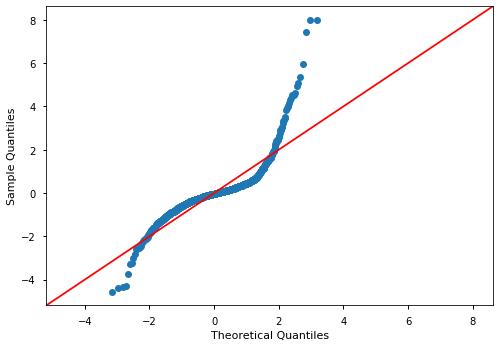

In [86]:
## Create a string representing the right side of the ~ in our formula
features = ' + '.join(df_model.drop(['revenue',*remove_cols,
                                     'vote_count','runtime'],axis=1).columns)

## Create the final formula and create the model
f  = "revenue~"+features

model = smf.ols(f, df_model).fit()
display(model.summary())
sm.graphics.qqplot(model.resid,line='45',fit=True);

In [87]:
coeffs=model.params
coeffs.sort_values().round(2)

Intercept      -246,167,819.05
budget                    3.16
popularity        1,477,488.81
vote_average     32,205,277.17
dtype: float64

In [88]:
## Create the final formula and create the model
df

,imdb_id,original_title,title,mpaa_rating,release_date,runtime,budget,revenue,vote_count,vote_average,popularity,adult,original_language
id,,,,,,,,,,,,,
24428,tt0848228,The Avengers,The Avengers,PG_13,2012-04-25,143.0,220000000,1518815515,24252,7.7,151.095,False,en
50620,tt1673434,The Twilight Saga: Breaking Dawn - Part 2,The Twilight Saga: Breaking Dawn - Part 2,PG_13,2012-11-13,115.0,120000000,829000000,6978,6.5,73.226,False,en
82690,tt1772341,Wreck-It Ralph,Wreck-It Ralph,PG,2012-11-01,101.0,165000000,471222889,9690,7.3,70.213,False,en
57214,tt1636826,Project X,Project X,R,2012-03-01,88.0,12000000,100000000,4399,6.7,67.687,False,en
49051,tt0903624,The Hobbit: An Unexpected Journey,The Hobbit: An Unexpected Journey,PG_13,2012-11-26,169.0,250000000,1021103568,14539,7.3,61.052,False,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...
403300,tt5827916,A Hidden Life,A Hidden Life,PG_13,2019-12-11,174.0,9000000,4612788,370,7.2,15.434,False,en
520900,tt6439020,The Personal History of David Copperfield,The Personal History of David Copperfield,PG,2019-11-07,119.0,15600000,11620337,211,6.7,15.076,False,en
616584,tt10521814,K-12,K-12,R,2019-09-05,92.0,50000,359377,171,7.6,14.822,False,en


In [89]:
num_cols = [col for col in df_model.columns if col.startswith('mpaa')==False]
# num_cols.remove('revenue')
num_cols

['runtime', 'budget', 'revenue', 'vote_count', 'vote_average', 'popularity']

In [90]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler

StandardScaler()

In [91]:
df_scaled = df_model.copy()
df_scaled[num_cols] = scaler.fit_transform(df_scaled[num_cols])
df_scaled.describe().round()

,runtime,budget,revenue,vote_count,vote_average,popularity,mpaa_rating_NC_17,mpaa_rating_NR,mpaa_rating_PG,mpaa_rating_PG_13,mpaa_rating_R
count,"1,300.0","1,300.0","1,300.0","1,300.0","1,300.0","1,300.0","1,300.0","1,300.0","1,300.0","1,300.0","1,300.0"
mean,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
min,-2.0,-1.0,-1.0,-1.0,-7.0,-1.0,0.0,0.0,0.0,0.0,0.0
25%,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0
50%,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0
75%,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
max,5.0,6.0,10.0,6.0,3.0,10.0,1.0,1.0,1.0,1.0,1.0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     425.6
Date:                Thu, 31 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:44:46   Log-Likelihood:                -896.20
No. Observations:                1300   AIC:                             1814.
Df Residuals:                    1289   BIC:                             1871.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.3359      0.164      2.049      0.041       0.014       0.657
runtime              -0.0340      0.017     -2.027      0.043      -0.067      -0.001
budget                0.4052      0.021     18.884      0.000       0.363       0.447
vote_count            0.4633      0.020     22.858      0.000       0.424       0.503
vote_average         -0.0171      0.016     -1.060      0.290      -0.049       0.015
popularity            0.1428      0.017      8.615      0.000       0.110       0.175
mpaa_rating_NC_17    -0.2959      0.514     -0.576      0.565      -1.304       0.712
mpaa_rating_NR       -0.2522      0.195     -1.291      0.197      -0.635       0.131
mpaa_rating_PG       -0.0919      0.166     -0.554      0.580      -0.418       0.234
mpaa_rating_PG_13    -0.3496      0.165     -2.116      0.035      -0.674      -0.025
mpaa_rating_R        -0.4034      0.166     -2.426      0.015      -0.730      -0.077
==============================================================================
Omnibus:                      849.330   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25908.797
Skew:                           2.547   Prob(JB):                         0.00
Kurtosis:                      24.269   Cond. No.                         65.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

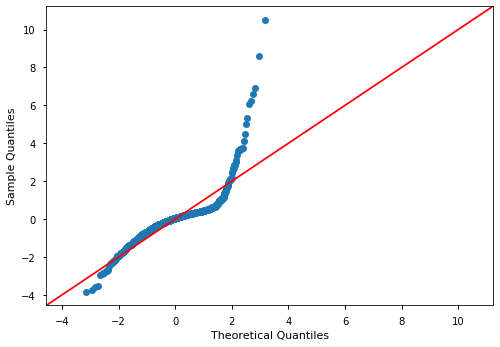

In [92]:
## Drop any multicollinear features
# None

## Create a string representing the right side of the ~ in our formula
features = ' + '.join(df_scaled.drop('revenue',axis=1).columns)

## Create the final formula and create the model
f  = "revenue~"+features

model = smf.ols(f, df_scaled).fit()
display(model.summary())
sm.graphics.qqplot(model.resid,line='45',fit=True);

In [93]:
coeffs = model.params.sort_values().to_frame('Coeffs')
coeffs['Abs'] = coeffs['Coeffs'].abs()
coeffs.sort_values('Abs',ascending=False,inplace=True)
coeffs.round(2)

,Coeffs,Abs
vote_count,0.46,0.46
budget,0.41,0.41
mpaa_rating_R,-0.4,0.4
mpaa_rating_PG_13,-0.35,0.35
Intercept,0.34,0.34
mpaa_rating_NC_17,-0.3,0.3
mpaa_rating_NR,-0.25,0.25
popularity,0.14,0.14
mpaa_rating_PG,-0.09,0.09
runtime,-0.03,0.03


In [94]:
keep_me = list(coeffs[coeffs['Abs'] > .08].index)
keep_me.remove('Intercept')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     529.0
Date:                Thu, 31 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:44:46   Log-Likelihood:                -899.86
No. Observations:                1300   AIC:                             1818.
Df Residuals:                    1291   BIC:                             1864.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.3636      0.163      2.235      0.026       0.044       0.683
vote_count            0.4458      0.019     24.025      0.000       0.409       0.482
budget                0.3989      0.020     19.812      0.000       0.359       0.438
mpaa_rating_R        -0.4344      0.165     -2.638      0.008      -0.757      -0.111
mpaa_rating_PG_13    -0.3795      0.164     -2.316      0.021      -0.701      -0.058
mpaa_rating_NC_17    -0.3834      0.512     -0.748      0.454      -1.388       0.621
mpaa_rating_NR       -0.2608      0.194     -1.347      0.178      -0.641       0.119
popularity            0.1413      0.017      8.546      0.000       0.109       0.174
mpaa_rating_PG       -0.1056      0.166     -0.636      0.525      -0.431       0.220
==============================================================================
Omnibus:                      840.362   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24730.681
Skew:                           2.520   Prob(JB):                         0.00
Kurtosis:                      23.765   Cond. No.                         58.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

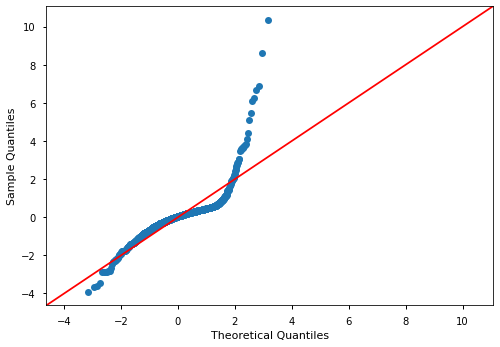

In [95]:
## Drop any multicollinear features
# None

## Create a string representing the right side of the ~ in our formula
features = ' + '.join(keep_me) #.join(df_scaled.drop('revenue',axis=1).columns)

## Create the final formula and create the model
f  = "revenue~"+features

model = smf.ols(f, df_scaled).fit()
display(model.summary())
sm.graphics.qqplot(model.resid,line='45',fit=True);

# [New] Activity - Part 2 

- Additional Topics to discuss tomorrow:
    - train-test-split/cross-validation
    - Using VIF to deal with multicollinearity
    - Using feature selection methods
    - Outlier removal

## Dealing with Multicollinearity with VIF

Definition: when 2 features are more related to each than the target.

> $\large V.I.F. = \frac{1}{(1 - R^2)} $<br>
- [VIF (Variance Inflation Factor)](https://etav.github.io/python/vif_factor_python.html) 
- [Wikipedia: VIF](https://en.wikipedia.org/wiki/Variance_inflation_factor)

- Statsmodels:
    - https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html

In [96]:
## MUST UPDATE FOR OUR TASK. For VIF
from statsmodels.stats.outliers_influence import (OLSInfluence,
                                                  variance_inflation_factor)
def calculate_vif():
    pass

## Train Test Split / Cross Validation

In [97]:
from sklearn.model_selection import (train_test_split, 
                                     cross_val_predict,
                                     cross_validate,
                                     cross_val_score)

In [98]:
df_train, df_test = train_test_split(df_model,random_state=42)
df_train.shape,df_test.shape

((975, 11), (325, 11))

In [100]:
df_train.shape, df_test.shape

((975, 11), (325, 11))

In [101]:
## Drop any multicollinear features
# None

## Create a string representing the right side of the ~ in our formula
features = ' + '.join(df_train.drop('revenue',axis=1).columns)

## Create the final formula and create the model
f  = "revenue~"+features
f

'revenue~runtime + budget + vote_count + vote_average + popularity + mpaa_rating_NC_17 + mpaa_rating_NR + mpaa_rating_PG + mpaa_rating_PG_13 + mpaa_rating_R'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     334.7
Date:                Thu, 31 Mar 2022   Prob (F-statistic):          2.32e-305
Time:                        16:45:00   Log-Likelihood:                -19599.
No. Observations:                 975   AIC:                         3.922e+04
Df Residuals:                     964   BIC:                         3.927e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          9.389e+07   5.96e+07      1.575      0.116   -2.31e+07    2.11e+08
runtime           -5.402e+05   3.01e+05     -1.792      0.073   -1.13e+06    5.14e+04
budget                2.1334      0.119     17.888      0.000       1.899       2.367
vote_count         3.237e+04   1652.493     19.590      0.000    2.91e+04    3.56e+04
vote_average      -2.951e+06   5.24e+06     -0.563      0.574   -1.32e+07    7.34e+06
popularity         9.149e+05   1.31e+05      6.995      0.000    6.58e+05    1.17e+06
mpaa_rating_NC_17 -7.237e+07    1.4e+08     -0.517      0.605   -3.47e+08    2.02e+08
mpaa_rating_NR    -6.373e+07   5.68e+07     -1.122      0.262   -1.75e+08    4.77e+07
mpaa_rating_PG    -2.081e+07    4.8e+07     -0.434      0.664   -1.15e+08    7.33e+07
mpaa_rating_PG_13 -9.616e+07   4.76e+07     -2.021      0.044    -1.9e+08   -2.78e+06
mpaa_rating_R     -1.032e+08   4.81e+07     -2.146      0.032   -1.98e+08   -8.84e+06
==============================================================================
Omnibus:                      588.038   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15828.707
Skew:                           2.261   Prob(JB):                         0.00
Kurtosis:                      22.214   Cond. No.                     2.56e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.56e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

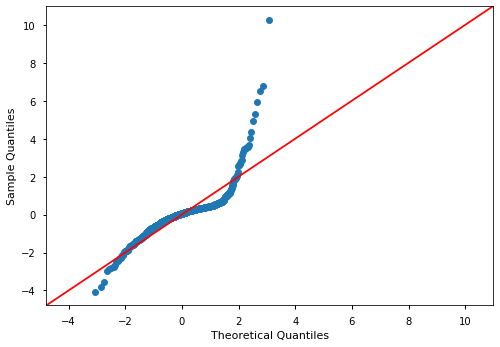

In [102]:
model = smf.ols(f, df_train).fit()
display(model.summary())
sm.graphics.qqplot(model.resid,line='45',fit=True);

In [103]:
from sklearn import metrics

In [80]:
y_hat_train = model.predict(df_train)
metrics.r2_score(df_train['revenue'],y_hat_train)

0.7764017624239951

In [82]:
y_hat_test = model.predict(df_test)
metrics.r2_score(df_test['revenue'],y_hat_test)

0.7293542539534115

In [83]:
from sklearn.linear_model import LinearRegression

In [85]:
y = df_model['revenue'].copy()
X = df_model.drop('revenue',axis=1).copy()


X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
X_train.shape,X_test.shape

((975, 10), (325, 10))

In [87]:
reg = LinearRegression()
reg.fit(X_train, y_train)
reg.score(X_train,y_train)

0.7764017624239951

In [88]:
reg.score(X_test,y_test)

0.7293542539635622

In [89]:
results = cross_validate(reg,X_train, y_train,cv=10)
results

{'fit_time': array([0.00376177, 0.00349593, 0.00387406, 0.00335383, 0.00361681,
        0.00302505, 0.00340104, 0.00409603, 0.00457406, 0.00301003]),
 'score_time': array([0.00281501, 0.00391698, 0.00238895, 0.00225616, 0.00202394,
        0.0029459 , 0.0021131 , 0.00241089, 0.00312018, 0.002038  ]),
 'test_score': array([0.57128848, 0.58422893, 0.80301134, 0.87397601, 0.76983391,
        0.73577135, 0.60631994, 0.74843037, 0.7903412 , 0.89025789])}

In [92]:
results['test_score'].mean()

0.7373459432370459

<AxesSubplot:>

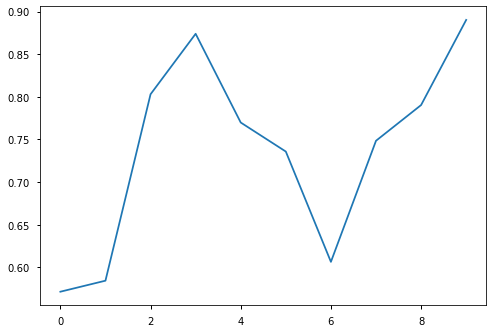

In [91]:
ax = pd.Series(results['test_score']).plot()

In [93]:
y_hat_cross = cross_val_predict(reg, X_train, y_train,cv=10)
metrics.r2_score(y_train,y_hat_cross)

0.7650856172199471